In [1]:
%pylab notebook

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers
import tensorflow.keras.backend as K

import primo.models
import primo.datasets
import primo.tools.sequences as seqtools

from copy import deepcopy

from primo.models.cas9_keras import log10_crispr_spec, log10_norm_crispr_spec, linear_crispr_spec

from primo.models.encoder import entropy_regularizer

gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-uz1w2j8m because the default path (/tf/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


Populating the interactive namespace from numpy and matplotlib
1 Physical GPUs, 1 Logical GPUs


In [2]:
train_dataset = primo.datasets.OpenImagesTrain(
    '/tf/open_images/train/', switch_every=10**5
)
validation_dataset = primo.datasets.OpenImagesVal('/tf/open_images/validation/')

def keras_batch_generator(dataset_batch_generator, similarity_threshold):
    # Yield datasets
    # TODO: Verify with Callie this understanding is correct https://github.com/uwmisl/cas9-similarity-search/issues/2
    while True:
        # This tuple contains:
        # indices: a positive integer uniquely identifying an image. This index is obtained by enumerating all the images in the dataset (before splitting them into test/train/validate datasets)
        # pairs:
        indices, pairs = next(dataset_batch_generator)
        # The Euclidean distances between the two vectors in each pair
        distances = np.sqrt(np.square(pairs[:,0,:] - pairs[:,1,:]).sum(1))
        # Whether or not the images in this pair should be considered 'similar'. This is a boolean value, represented by an int (0 or 1), and is determined by whether the aforementioned Euclidean distances between image feature vectors are under some pre-deterined "similarity threshold".
        similar = (distances < similarity_threshold).astype(int)
        # Yield a pair of sequences, and 0-or-1 indicating whether they're similar.
        yield pairs, similar

# To see how this value was derived, please consult the Materials and Methods subsection under Feature Extraction section.
similarity_threshold = 75
# Intuitively determined:
batch_size = 150
val_batch_size = 150

train_batch_generator = keras_batch_generator(
    train_dataset.balanced_pairs(batch_size, similarity_threshold),
    similarity_threshold
)

val_batch_generator = keras_batch_generator(
    validation_dataset.balanced_pairs(val_batch_size, similarity_threshold),
    similarity_threshold
)
        
train_inputs, train_targets = next(train_batch_generator)

switching to train_d.h5 and train_9.h5


In [29]:
def make_multisite_predictor(predictor):
    """Return a function that will predict multiple sites using the predictor
    function provided to score each
    
    Combined probability is 1 - (1 - P(site1)) * (1 - P(site2)) ... * (1 - P(siteN))
    """
    def multisite_predict(seq_pairs):
        n_sites = int(seq_pairs.shape[2] / 20)
        # Split into separate sites
        sites = tf.stack(tf.split(seq_pairs, n_sites, axis=2))
        # Apply predictor to sites independently
        scores = tf.map_fn(tf.function(predictor), sites)
        #scores *= tf.sqrt(tf.reduce_mean(tf.reduce_max(seq_pairs, axis=-1)))
        # Compute combined probability|
        return 2 * (tf.sigmoid(3*tf.sqrt(tf.reduce_sum(scores, axis=0))) - 0.5)
        #return 1 - tf.reduce_prod(1 - scores, axis=0)

    return multisite_predict


In [4]:
f = make_multisite_predictor(linear_crispr_spec(-0.5))
seqs = calcseq.predict(train_inputs)

plt.figure(); plt.plot(seqs[1].max(-1)[0])


NameError: name 'calcseq' is not defined

In [72]:
OUTPUT_LEN = 60

encoder = tf.keras.Sequential([
    layers.Dense(4096, activation = 'relu', activity_regularizer=tf.keras.regularizers.l2(0.0)),
    layers.Dropout(0.5),
    layers.Dense(2048, activation = 'relu', activity_regularizer=tf.keras.regularizers.l2(0.001)),
    layers.Dropout(0.5),
    layers.Dense(OUTPUT_LEN * 4, activation='relu'),
    layers.Reshape([OUTPUT_LEN, 4]),
    layers.Activation('softmax'),
    layers.Lambda(
        # Just using the identity because we don't want to transform the softmaxxed output,
        # we just want to make sure we learn an output encoding that's regularized (i.e. not crazy complex/over-fitting)
        lambda x: x,

        # In inference mode, this does nothing (just passes identity), but when training, this regularizes
        # the activations.
        # Using an "entropy" regulator because we passed the output through a softmax.
        activity_regularizer=entropy_regularizer(
            0.01
        )
    )

], name='encoder')


#encoder = tf.keras.models.load_model('/tf/primo/data/models/exp_encoder_2.h5')

# from primo.models.encoder import ClusteringLayer
# import pickle
# with open('/tf/primo/data/clusters_kmeans_64.pkl', 'rb') as f:
#     kmodel = pickle.loads(f.read())
# kmeans = kmodel.cluster_centers_
# encoder = tf.keras.Sequential([
#     ClusteringLayer(kmeans.shape[0], kmeans, input_dim=4096, alpha=25.0),
#     layers.Dense(1024, activation = 'relu'),
#     layers.Dense(OUTPUT_LEN * 4, activation='relu'),
#     layers.Reshape([OUTPUT_LEN, 4]),
#     layers.Activation('softmax'),
# ], name='encoder')

X_pairs = layers.Input([2, 4096])

# Essentially, we started with ]a batch of feature-vector pairs...
# ...And turned them into a pair of feature-vector batches.
X1, X2 = layers.Lambda(lambda X: (X[:,0,:], X[:,1,:]))(X_pairs)

distances = layers.Lambda(lambda Xs: tf.sqrt(tf.reduce_sum(tf.square(Xs[0]-Xs[1]), axis=1)))([X1,X2])

# Independently transforms the batches of feature vectors into soft-max encoded DNA sequences.
S1 = encoder(X1)
S2 = encoder(X2)

# Glue them back together! Back into a batch of feature vector pairs.
S_pairs = layers.Lambda(
    lambda Ss: tf.stack(Ss, axis=-1)
)([S1,S2])

# Dimensions: (batch_size x 80 x 4 x 2 ) (i.e. batch size x DNA length x # of nucleotides x 2)

# Swaps dimensions for the predictor, which wants (batch-size x 2 x DNA length x 4)
S_pairs_T = layers.Lambda(lambda S: tf.transpose(S, [0, 3, 1, 2]))(S_pairs)

# y_h: Estimated output
#y_h = layers.Lambda(tf.function(make_multisite_predictor(log10_norm_crispr_spec)))(S_pairs_T)
y_h = layers.Lambda(tf.function(make_multisite_predictor(linear_crispr_spec(-0.7))))(S_pairs_T)
# y_h = layers.Lambda(tf.function(linear_crispr_spec(-1)))(S_pairs_T)

y_h_T = layers.Reshape([1])(y_h)
    
calcseq = tf.keras.Model(inputs=X_pairs, outputs=S_pairs_T)
calcdists = tf.keras.Model(inputs=X_pairs, outputs=distances)
encoder_trainer = tf.keras.Model(inputs=X_pairs, outputs=y_h_T)

print(encoder.summary())
# Initialize with previously trained weights
encoder.load_weights('/tf/primo/data/models/encoder_3site_2.h5')


Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_30 (Dense)             (None, 4096)              16781312  
_________________________________________________________________
dropout_20 (Dropout)         (None, 4096)              0         
_________________________________________________________________
dense_31 (Dense)             (None, 2048)              8390656   
_________________________________________________________________
dropout_21 (Dropout)         (None, 2048)              0         
_________________________________________________________________
dense_32 (Dense)             (None, 240)               491760    
_________________________________________________________________
reshape_16 (Reshape)         (None, 60, 4)             0         
_________________________________________________________________
activation_10 (Activation)   (None, 60, 4)             0   

In [6]:
import secrets 

def UniquenessMetric(y_true, y_pred):
    """Use a single batch of inputs to measure sequence uniqueness while training"""
    seqs = calcseq(train_inputs)
    # Reduce seqs to a single base (e.g. [0.6, 0.2, 0.1, 0.1] -> [0])
    rounded_seqs = K.argmax(seqs[:, 0, :, :], axis=-1)
    # Now each sample is array of 20 integers, 0-3. Multiply each position by 4**n to make
    # a unique integer for each possible 20bp sequence
    unique_seqs = np.unique(K.get_value(rounded_seqs), axis=0)
    #hashed_seqs = tf.reduce_sum(rounded_seqs * (4 ** tf.range(0, 20, dtype=tf.int64)), axis=-1)
    # Get unique ones
    #unique_seqs, _ = tf.unique(hashed_seqs)
    # Return ratio of unique to input
    return float(len(unique_seqs)) / len(train_inputs)

def ConfidenceMetric(batch):
    """Uses a single batch of inputs to measure sequence uniqueness while training"""
    def confidence(_y_true, _y_pred):
        seqs = calcseq(batch)
        # Get the highest probabilty value for each base
        max_seqs = tf.reduce_max(seqs, axis=-1)
        # Take mean along both batch and seqence dimensions
        return tf.reduce_mean(max_seqs)
    return confidence

class EarlyStopCallback(keras.callbacks.Callback):
    def __init__(self, **kwargs):
        uid = secrets.token_hex(4)
        self.__file = f'/tf/primo/signals/{uid}'
        print(f"Touch {self.__file} to terminate training early")
        super().__init__(**kwargs)


    def on_batch_end(self, batch, logs={}):
        if os.path.exists(self.__file):
          print (f"\nStopping at Epoch {self.epoch}, Batch {batch}")
          self.model.stop_training = True

    

In [74]:
encoder_trainer.compile(
    tf.keras.optimizers.Adagrad(1e-3, clipnorm=1.0),
    'binary_crossentropy',
    run_eagerly=True,
    metrics=[
        UniquenessMetric,
        ConfidenceMetric(train_inputs),
        tf.keras.metrics.Precision(), 
        tf.keras.metrics.Recall(),
        'accuracy'])
history = encoder_trainer.fit(
    train_batch_generator,
    validation_data=val_batch_generator,
    validation_steps=5,
    steps_per_epoch=500,
    epochs=30)

Epoch 1/30
500/500 [==============================] - 54s 107ms/step - loss: 0.5891 - UniquenessMetric: 0.3072 - confidence: 0.8248 - precision_1: 0.8420 - recall_1: 0.7975 - accuracy: 0.8240 - val_loss: 0.6693 - val_UniquenessMetric: 0.2933 - val_confidence: 0.8123 - val_precision_1: 0.9545 - val_recall_1: 0.5615 - val_accuracy: 0.7680
Epoch 2/30
500/500 [==============================] - 54s 108ms/step - loss: 0.5571 - UniquenessMetric: 0.2779 - confidence: 0.8064 - precision_1: 0.8299 - recall_1: 0.8073 - accuracy: 0.8207 - val_loss: 0.7086 - val_UniquenessMetric: 0.2600 - val_confidence: 0.8009 - val_precision_1: 0.9320 - val_recall_1: 0.5161 - val_accuracy: 0.7413
Epoch 3/30
500/500 [==============================] - 54s 107ms/step - loss: 0.5488 - UniquenessMetric: 0.2577 - confidence: 0.7976 - precision_1: 0.8221 - recall_1: 0.8067 - accuracy: 0.8163 - val_loss: 0.6968 - val_UniquenessMetric: 0.2467 - val_confidence: 0.7938 - val_precision_1: 0.9171 - val_recall_1: 0.5364 - val_

500/500 [==============================] - 53s 106ms/step - loss: 0.4625 - UniquenessMetric: 0.2372 - confidence: 0.7259 - precision_1: 0.8289 - recall_1: 0.8401 - accuracy: 0.8332 - val_loss: 0.6490 - val_UniquenessMetric: 0.2400 - val_confidence: 0.7256 - val_precision_1: 0.9522 - val_recall_1: 0.5321 - val_accuracy: 0.7533
Epoch 25/30
500/500 [==============================] - 53s 106ms/step - loss: 0.4600 - UniquenessMetric: 0.2385 - confidence: 0.7249 - precision_1: 0.8305 - recall_1: 0.8379 - accuracy: 0.8334 - val_loss: 0.6548 - val_UniquenessMetric: 0.2333 - val_confidence: 0.7218 - val_precision_1: 0.9476 - val_recall_1: 0.4814 - val_accuracy: 0.7267
Epoch 26/30
500/500 [==============================] - 53s 105ms/step - loss: 0.4561 - UniquenessMetric: 0.2348 - confidence: 0.7227 - precision_1: 0.8299 - recall_1: 0.8422 - accuracy: 0.8346 - val_loss: 0.7394 - val_UniquenessMetric: 0.2400 - val_confidence: 0.7170 - val_precision_1: 0.9598 - val_recall_1: 0.4441 - val_accuracy:

In [40]:
encoder_trainer.compile(tf.keras.optimizers.Adagrad(1e-2), 'binary_crossentropy')
history = encoder_trainer.fit(train_inputs, train_targets, epochs=200)

Epoch 1/200
5/5 [==============================] - 1s 9ms/step - loss: 4.4705
Epoch 2/200
5/5 [==============================] - 0s 9ms/step - loss: 2.1444
Epoch 3/200
5/5 [==============================] - 0s 10ms/step - loss: 1.9519
Epoch 4/200
5/5 [==============================] - 0s 9ms/step - loss: 1.8029
Epoch 5/200
5/5 [==============================] - 0s 9ms/step - loss: 1.7064
Epoch 6/200
5/5 [==============================] - 0s 9ms/step - loss: 1.6450
Epoch 7/200
5/5 [==============================] - 0s 9ms/step - loss: 1.4850
Epoch 8/200
5/5 [==============================] - 0s 10ms/step - loss: 1.3478
Epoch 9/200
5/5 [==============================] - 0s 10ms/step - loss: 1.3289
Epoch 10/200
5/5 [==============================] - 0s 9ms/step - loss: 1.1587
Epoch 11/200
5/5 [==============================] - 0s 10ms/step - loss: 1.1114
Epoch 12/200
5/5 [==============================] - 0s 9ms/step - loss: 1.0604
Epoch 13/200
5/5 [==============================] - 0s 9m

In [63]:

encoder.save('/tf/primo/data/models/encoder_3site_2.h5')

<IPython.core.display.Javascript object>


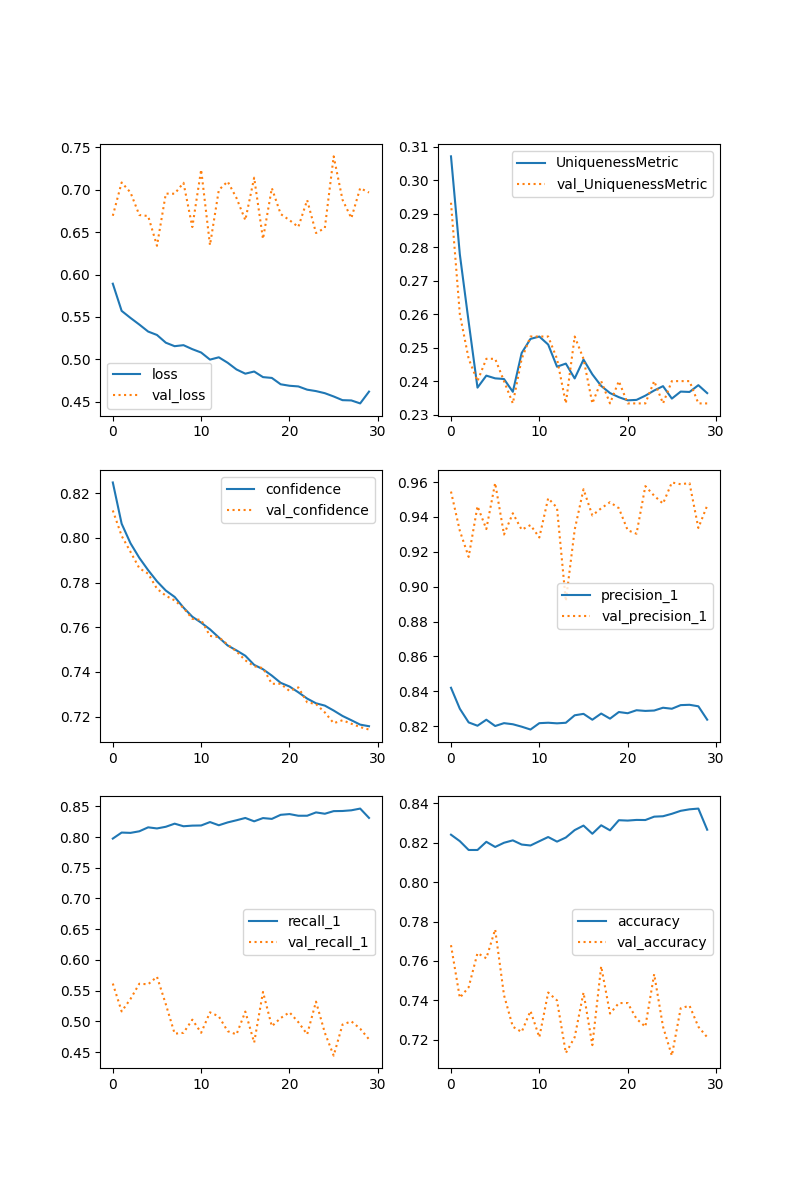

In [75]:
fig = plt.figure(figsize=(8, 12))
lines = [k for k in history.history.keys() if not k.startswith('val_')]

axes = fig.subplots(int(len(lines)/2), 2).flatten()
for i in range(len(lines)):
    label = lines[i]
    try:
        ax = axes[i]
    except TypeError:
        ax = axes
    
    val_label = 'val_' + label

    ax.plot(history.history[label], label=label)
    if val_label in history.history:
        ax.plot(history.history[val_label], linestyle=':', label=val_label)
    ax.legend()

    

<IPython.core.display.Javascript object>


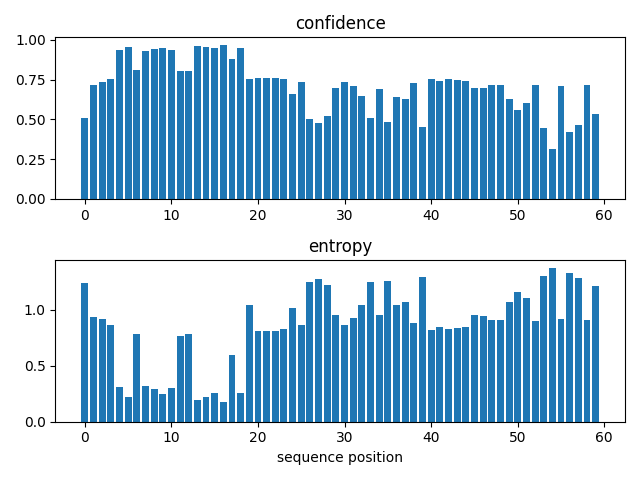

In [76]:
def confidence_by_base(sequences):
    """Takes a batch of softmax sequences, and returns vector of average confidence in each position
    
    sequences: Number of exmaple x Number of bases x 4
    
    Returns: 1 x number of bases
    """
    # reduce last dimension to max base number
    return np.mean(np.max(sequences, axis=-1), axis=0)

def entropy_by_base(sequences):
    x = np.sum(sequences, axis=0)
    x /= np.sum(x, axis=1)[:, None]
    entropy = -np.sum(x * np.log(x + 1e-10), axis=1)
    return entropy

def one_hot(nparray, depth = 0, on_value = 1, off_value = 0):
    if depth == 0:
        depth = np.max(nparray) + 1
    assert np.max(nparray) < depth, "the max index of nparray: {} is larger than depth: {}".format(np.max(nparray), depth)
    shape = nparray.shape
    out = np.ones((*shape, depth)) * off_value
    indices = []
    for i in range(nparray.ndim):
        tiles = [1] * nparray.ndim
        s = [1] * nparray.ndim
        s[i] = -1
        r = np.arange(shape[i]).reshape(s)
        if i > 0:
            tiles[i-1] = shape[i-1]
            r = np.tile(r, tiles)
        indices.append(r)
    indices.append(nparray)
    out[tuple(indices)] = on_value
    return out

seqs_softmax = calcseq.predict(train_inputs)[:, 0, :, :]
#seqs_onehot = one_hot(seqs_softmax.argmax(-1))

confidence = confidence_by_base(seqs_softmax)
entropy = entropy_by_base(seqs_softmax)

seqlen = seqs_softmax.shape[1]
fig = plt.figure()
axes = fig.subplots(2,1)
ax = axes[0]
ax.bar(np.arange(0, seqlen), confidence)
ax.set_title('confidence')
ax = axes[1]
ax.bar(np.arange(0, seqlen), entropy)
ax.set_title('entropy')
ax.set_xlabel('sequence position')
plt.tight_layout()

<IPython.core.display.Javascript object>


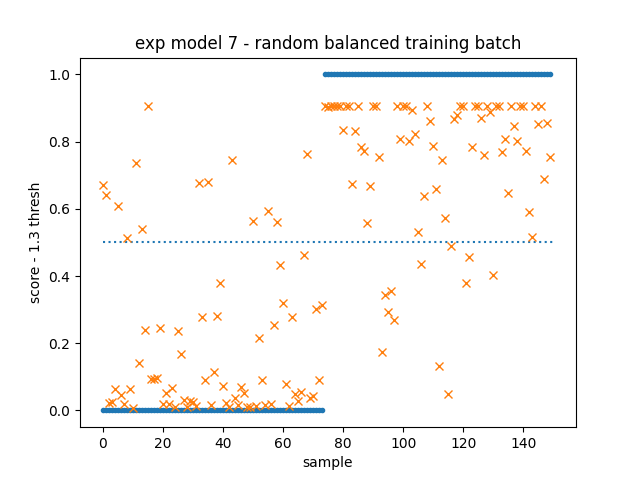

(150,)
(150,)


Text(0.5, 1.0, 'exp model 7 - random balanced training batch')

In [77]:
idx = train_targets.argsort()

Y = encoder_trainer.predict(train_inputs)

seqs = calcseq.predict(train_inputs)
plt.figure()

print(train_targets.shape)
print((Y[:, 0] - train_targets).shape)
plt.plot(train_targets[idx], '.')
plt.plot(Y[idx][:, 0], 'x')
plt.hlines(0.5, 0, len(seqs), linestyle=':')
plt.ylabel('score - 1.3 thresh')
plt.xlabel('sample')
plt.title('exp model 7 - random balanced training batch')

<IPython.core.display.Javascript object>


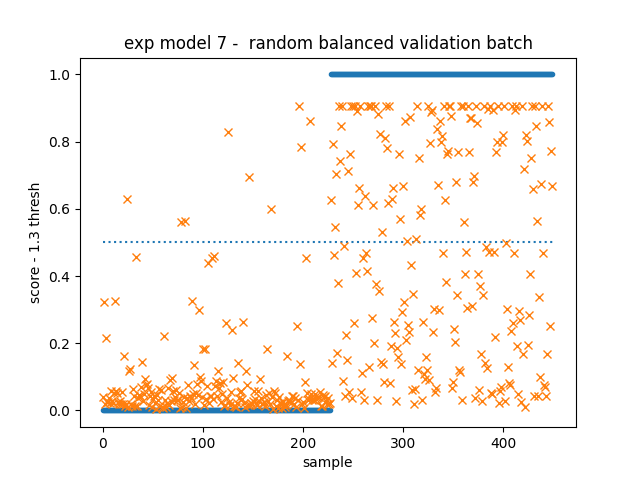

(450,)
(450,)


Text(0.5, 1.0, 'exp model 7 -  random balanced validation batch')

In [78]:
def get_batchs(n, generator):
    inputs = None
    target = None
    for _ in range(n):
        i, t = next(generator)
        if inputs is None:
            inputs = i
            targets = t
        else:
            inputs = np.concatenate([inputs, i])
            targets = np.concatenate([targets, t])
    return inputs, targets

#val_inputs, val_targets = next(val_batch_generator)
val_inputs, val_targets = get_batchs(3, val_batch_generator)

idx = val_targets.argsort()
Y = encoder_trainer.predict(val_inputs)
plt.figure()

print(val_targets.shape)
print((Y[:, 0] - val_targets).shape)
plt.plot(val_targets[idx], '.')
plt.plot(Y[idx][:, 0], 'x')
plt.hlines(0.5, 0, len(Y), linestyle=':')
plt.ylabel('score - 1.3 thresh')
plt.xlabel('sample')
plt.title('exp model 7 -  random balanced validation batch')



<IPython.core.display.Javascript object>


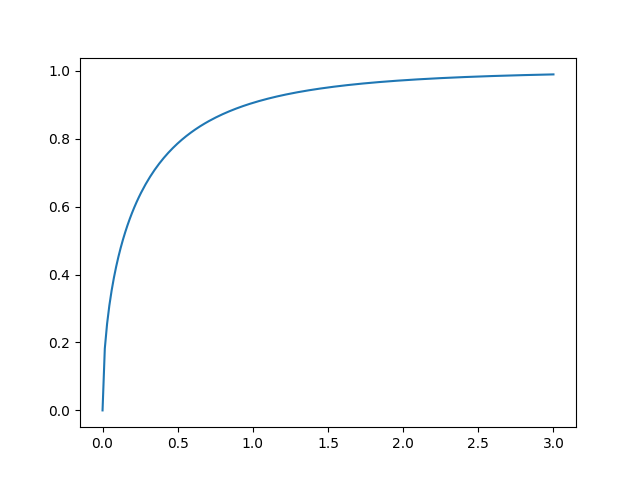

In [51]:
x = np.linspace(0, 3.0, 200)
y = 2 * (tf.sigmoid(3*sqrt(x)) - 0.5)#- tf.math.log(1. / x - 1.)
plt.figure(); plt.plot(x, y)

In [68]:
seqs = calcseq.predict(train_inputs)
all_seqs = seqs[:, 0, :, :] #np.concatenate([seqs[:, 0, :, :], seqs[:, 1, :, :]])

seq_strings = seqtools.onehots_to_seqs(all_seqs)
print(len(np.unique(all_seqs.argmax(-1), axis=0)))
unique = np.unique(seq_strings)
print(unique)
print(f"{len(unique)} / {len(all_seqs)}")



148
['AAAAACGTTACCGAAACAAATAGCCAGTTCAGTAAGTGTTACTACAACATAAGTTTGCAT'
 'AAATACGTTAACGAAACAAATCGCCCCCCCTGTAGGTATCACGTGAATGTAATCCTGCTT'
 'AAGGGCGTTAGCGAAACAAATAACCAAACCAGTAGCTATAACTCCAATGAGAGCCTGAGT'
 'AAGTACGTTAACGAAACAAATCGCCCAACCAGTAGGTGTAACGTCAAAGCAATCCTGCTT'
 'ACATACGTTAACGAAACAAATCGCCCATCCAGTAGGTGTCACTCCAAAACAAGCCTGCGT'
 'ACATACGTTACCGAAACAAATCTCCCGACCTCTAGGTAGAACGTCAAGGAAAGGCTGCTT'
 'ACATACGTTATCGAAACAAATCGCCCGTCCAGTAGGTGTTACGCCAAAACAAGCATGCCT'
 'ACATGCGTTAACGAAACAAATCGCCCGTCCAGTAGATGTAACTCCAATGCAAGCCTGCGT'
 'ACATGCGTTAACGAAACAAATCGCTCATCCAGTAGCCGTCACTCCAATATAAGCCTGTGT'
 'ACATGCGTTATCGAAACAAAGCGCCCAACCAGTAGCCGTAACTCCAACACAAGCCTGCGT'
 'ACATGCGTTATCGAAACAAATCGCCCCACCAGTAGGTATCACGTCAAAGCAATCATGCTT'
 'ACCACCGTCCGCGAAAGAAATGTCCAGCCTGGAAGCCATGACCCGAAAATAAGCATGCAT'
 'ACCCCGGGCCCCGAAAGAAAATTCCATACAACAAGCAGCGCCGTAGACATCACCATGCAT'
 'ACCCCGGGCCGCGAAAGAAAGCTCCAGTGAGGTAGACTGTCAGTCTAAAGAGACATGCCG'
 'ACCTACGTTACCGAAACAAATCTCCCTTCCAGTGAGTATCACGTCAAAGTAAGCCTGATT'
 'ACCTGCGTTATCGAAACAAAGCGCCCAACCAGTA

In [69]:
all_seqs[7]

array([[3.3259562e-01, 2.2246814e-01, 2.2246814e-01, 2.2246814e-01],
       [2.3982550e-01, 2.3982550e-01, 2.5065073e-01, 2.6969826e-01],
       [2.3638621e-01, 2.4142413e-01, 2.4318433e-01, 2.7900538e-01],
       [2.1367773e-01, 3.4356976e-01, 2.1367773e-01, 2.2907479e-01],
       [9.8940629e-01, 1.3364973e-03, 1.3364973e-03, 7.9207430e-03],
       [2.9965704e-05, 2.9965704e-05, 9.9991012e-01, 2.9965704e-05],
       [1.9041627e-05, 1.9041627e-05, 1.9041627e-05, 9.9994290e-01],
       [4.0534575e-05, 9.9987841e-01, 4.0534575e-05, 4.0534575e-05],
       [7.5619275e-05, 9.9977320e-01, 7.5619275e-05, 7.5619275e-05],
       [9.9974197e-01, 8.1249840e-05, 9.5489420e-05, 8.1249840e-05],
       [2.5000000e-01, 2.5000000e-01, 2.5000000e-01, 2.5000000e-01],
       [2.3508541e-05, 2.3508541e-05, 9.9992955e-01, 2.3508541e-05],
       [3.7527036e-05, 3.7527036e-05, 3.7527036e-05, 9.9988735e-01],
       [9.9994814e-01, 1.7283641e-05, 1.7283641e-05, 1.7283641e-05],
       [9.9995112e-01, 1.6294385e-

In [9]:
# weights = [tensor for tensor in encoder_trainer.trainable_weights]# if encoder_trainer.get_layer(tensor.name[:-2]).trainable]
# optimizer = encoder_trainer.optimizer
# loss = tf.keras.metrics.BinaryCrossentropy(from_logits=False)(y_h_T, train_targets)
# g = optimizer.get_gradients(loss, weights)

with tf.GradientTape() as tape:
    # Doing the computation in the context of the gradient tape
    # For example computing loss
    pred = encoder_trainer(train_inputs)
    loss = tf.metrics.MSE(train_targets,pred)
    
# Getting the gradient of weight w.r.t loss 
grad = tape.gradient(loss, encoder_trainer.trainable_weights) 
print(grad)
#print([tf.norm(g).numpy() for g in grad])

[<tf.Tensor: shape=(4096, 2048), dtype=float32, numpy=
array([[-0.00668996, -0.00442752, -0.01292114, ..., -0.00297812,
         0.00866672,  0.00046856],
       [-0.014083  , -0.0085131 , -0.01540488, ..., -0.00662993,
         0.01435623,  0.00218737],
       [-0.00739208, -0.00459306, -0.00793888, ..., -0.00424623,
         0.00936238,  0.00140106],
       ...,
       [-0.00707141, -0.0031601 , -0.00536229, ..., -0.00655378,
         0.01212534,  0.0022773 ],
       [-0.01130053, -0.00968682, -0.01601881, ..., -0.00374336,
         0.00950455,  0.00092499],
       [-0.00697468, -0.0061232 , -0.00847617, ..., -0.0014009 ,
         0.00568788,  0.00132537]], dtype=float32)>, <tf.Tensor: shape=(2048,), dtype=float32, numpy=
array([-0.01711289, -0.01263236, -0.01965856, ..., -0.00607363,
        0.01729374,  0.0022029 ], dtype=float32)>, <tf.Tensor: shape=(2048, 2048), dtype=float32, numpy=
array([[ 5.5676320e-04,  7.4185044e-02,  7.9013333e-02, ...,
        -1.9020287e-02, -2.8113823e-

In [10]:
# summarize history for loss
plt.figure()
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

<IPython.core.display.Javascript object>

In [11]:
sample_input = train_inputs[0]
inspect_layers = [encoder.model.layers[0].output, encoder.model.layers[3].output]
layers_model = tf.keras.Model(inputs=encoder.model.input, outputs=inspect_layers)
Y = layers_model.predict(sample_input)
print(Y)
plt.figure()
plt.plot(Y[0].T, '.')

AttributeError: 'Sequential' object has no attribute 'model'

In [ ]:
sim = primo.models.Simulator()
from primo.models.cas9 import crispr_specificity
crispr_specificity('TATGTAGAAAACTGCAAAAC', 'TATGTAGAAAACTGCAAAAC')

In [ ]:
x = np.array([[all_seqs[0], all_seqs[1]]])
print(x.shape)
print(f"linear: {linear_crispr_spec(tf.convert_to_tensor(x, dtype = tf.float32))}")
print(f"log10norm: {log10_norm_crispr_spec(tf.convert_to_tensor(x, dtype = tf.float32))}")
all_seqs[0].shape

In [ ]:
print(np.around(all_seqs[0], 4))